In [2]:
import numpy as np
import pandas as pd
#from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
#from matplotlib import gridspec
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import scipy
#from scipy import signal
#from scipy import ndimage
#from scipy.interpolate import interp1d
import IPython.display as ipd
from IPython.display import Image, Audio

import librosa

path_img = '../img/9.musically_informed_audio_decomposition/'
path_data = '../data_FMP/'

from utils.plot_tools import *

# Nonnegative Matrix Factorization (NMF)

- **NMF(Nonnegative Matrix Factorization)**(NMF)는 음수가 아닌 항목의 행렬 $V$를 역시 음수가 아닌 항목만 있는 두 개의 행렬 $W$ 및 $H$로 분해하는 기술이다.

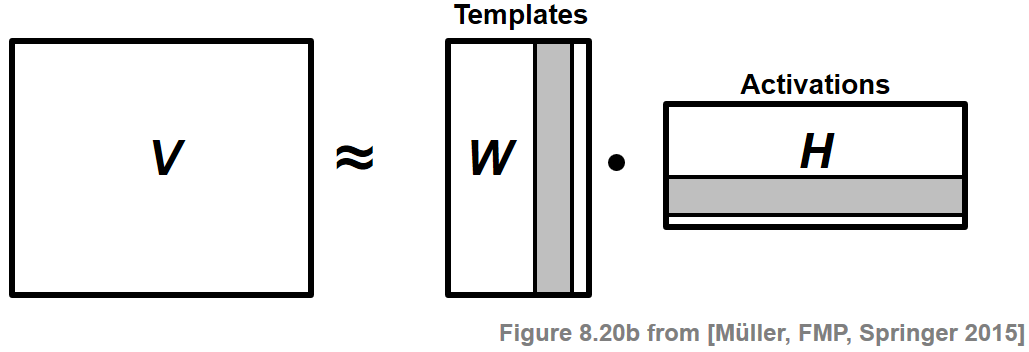

In [3]:
Image(path_img+"FMP_C8_F20b.png", width="400px")

- 일반적으로 행렬 $W$ 및 $H$는 원래 행렬 $V$보다 훨씬 낮은 rank를 가져야 한다. $V$의 열은 데이터 벡터로 간주된다. 기본 가정은 이러한 벡터가 상대적으로 적은 수의 **템플릿**(template) 벡터의 가중 중첩으로 표현될 수 있다는 것이다. $W$의 열은 이러한 템플릿에 해당한다. 또한 **활성화**(**activations**)라고 하는 $H$의 행은 이러한 템플릿이 $V$에서 발생하는 위치를 나타낸다.
- 음수가 아닌 제약 조건은 종종 계수의 의미 있는 해석을 허용하는 분해로 이어진다. 그러나 대부분의 경우 결과로 발생하는 분해 문제는 정확한 해가 없기 때문에 적절한 수치적 근사치를 찾기 위한 최적화 절차가 필요하다.
- 다음에서는 음악 도메인에서 인수분해 예제를 제공한다.

## 예시: 스펙트로그램 분해(Spectrogam Factorization)

- NMF의 예시로, 이 기술을 사용하여 음악 녹음의 스펙트로그램을 음악적으로 의미 있는 구성 요소로 분해하는 방법을 본다.
- Frédéric Chopin의 Prélude Op.28, No.4를 예로 보자. 다음 그림은 연주의 오디오 녹음과 동기화된 악보의 피아노 롤 표현과 악보를 보여준다. 설명을 위해 음표 번호 $p=71$와 관련된 모든 정보는 빨간색 직사각형 프레임으로 강조 표시되어 있다.

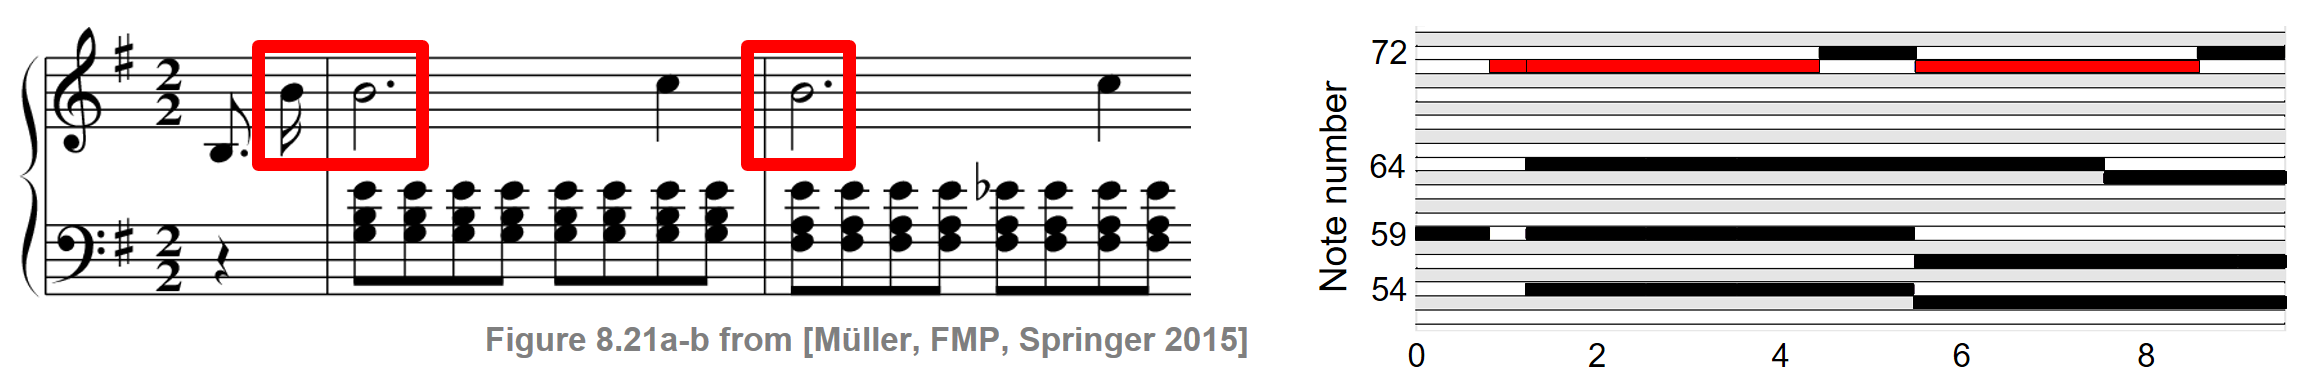

In [4]:
Image(path_img+"FMP_C8_F21a-b.png", width="600px")

- 원본 데이터 행렬 $V$는 스펙트럼 벡터의 시퀀스인 크기 STFT를 사용한다. NMF를 사용하면 이 행렬을 두 개의 비음수 행렬 $W$ 및 $H$의 곱으로 분해할 수 있다.
- 이상적인 경우 첫 번째 행렬 $W$는 음악에서 발생하는 음표 피치의 스펙트럼 패턴을 나타내고 두 번째 행렬 $H$는 오디오 녹음에서 이러한 스펙트럼 패턴이 활성화되는 시간 위치를 나타낸다. 다음 그림은 Chopin 예제에 대한 그러한 분해를 보여준다.

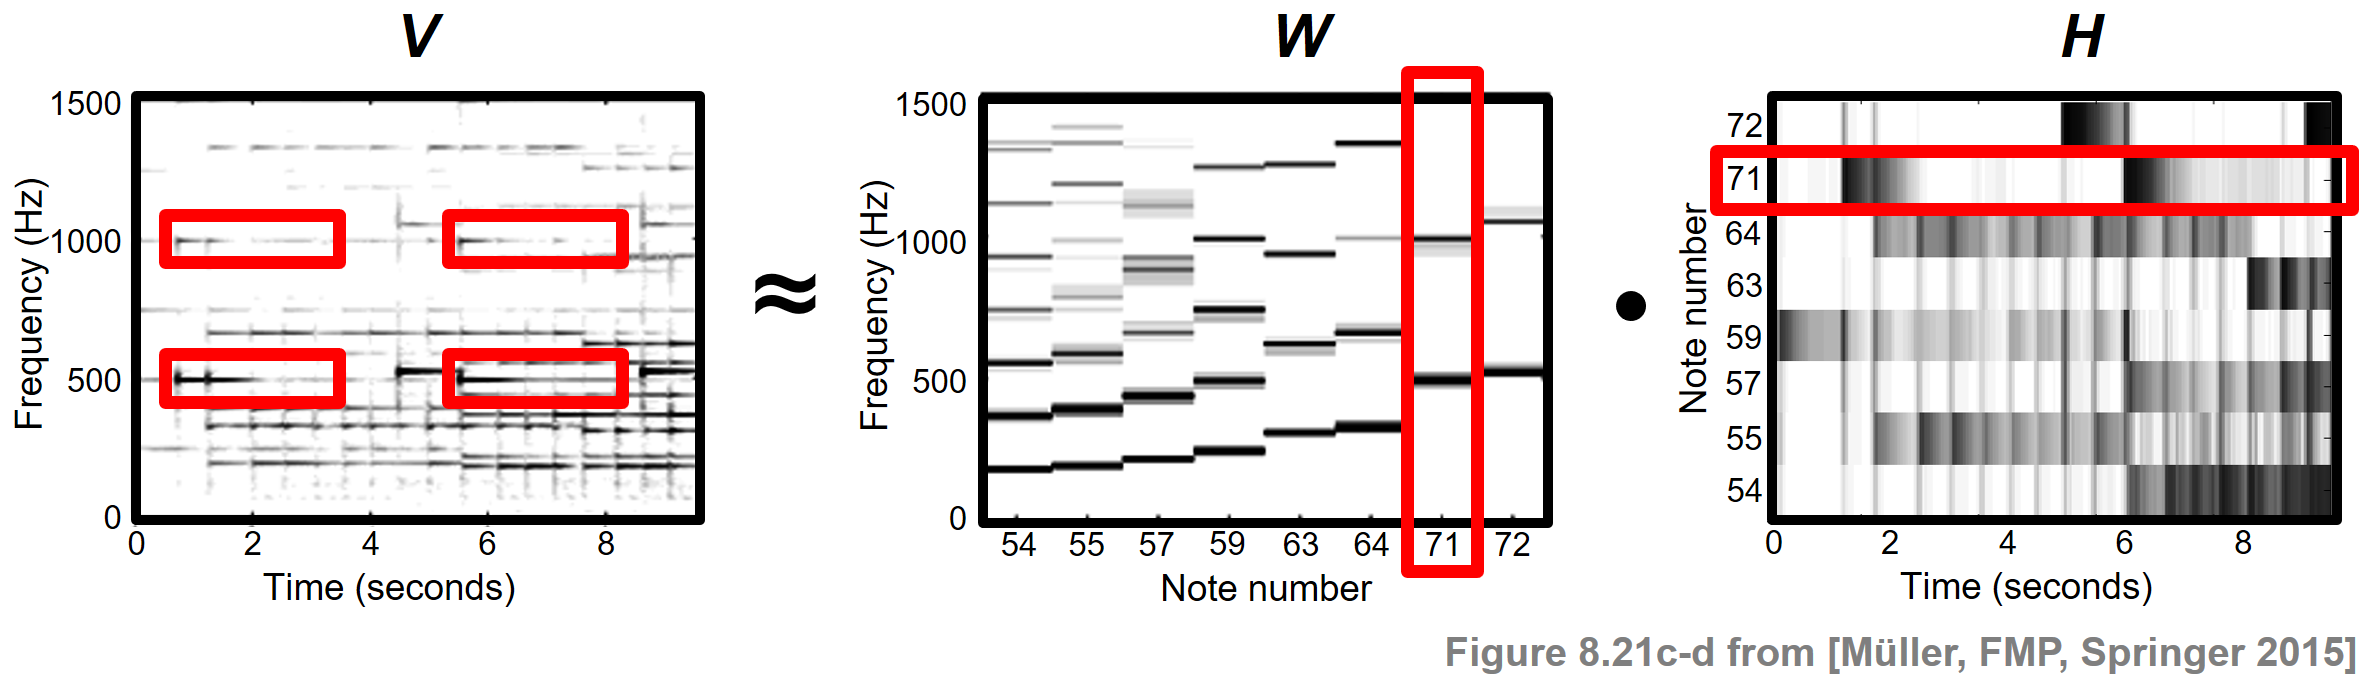

In [5]:
Image(path_img+"FMP_C8_F21c-e.png", width="700px")

- 이 경우 행렬 $W$로 지정된 각 템플릿은 특정 피치의 음이 $V$에서 스펙트럼적으로 구현되는 방식을 반영하고, 활성화 행렬 $H$는 악보의 피아노 롤 표현과 유사하게 보인다. 그러나 실제로는 어떤 신호 속성이 학습된 요인에 의해 궁극적으로 포착되는지 예측하기 어려운 경우가 많다.
- 이 분해를 더 잘 제어하기 위해 NMF가 음악적으로 의미 있는 분해를 생성하도록 제한하기 위해 추가 악보 정보를 사용할 수 있는 방법을 보기로 한다.

## NMF 정의

- $V \in \mathbb{R}_{\ge 0}^{K \times N}$가 $K\in\mathbb{N}$ 행과 $N\in\mathbb{N}$ 열을 가진 비음(**nonnegative**)행렬이라고 하자.  $K$ 및 $N$보다 작은 $R\in\mathbb{N}$가 주어지면 NMF의 목표는 두개의 비음행렬 $W \in \mathbb{R}_{\ge 0}^{K \times R}$ 및 $H \in \mathbb{R}_{\ge 0}^{R \times N}$를 찾는 것이다.: 
    - $V \approx W \cdot H$. 


- 앞서 언급한 바와 같이 $W$의 열 벡터는 **템플릿 벡터**(**template vectors**)라고도 하며 가중치 $H$는 **활성화**(**activations**)라고 한다. 

- $V \approx W \cdot H$를 찾으려면 근사의 품질을 정량화하는 거리 함수를 지정해야 한다. 다음에서는 **유클리드 거리**를 기반으로 한다. $A,B\in\mathbb{R}^{K \times N}$가 계수 $A_{kn}$ 및 $B_{kn}$ ($k\in[1:K]$, $n\in[1:N]$)를 갖는 두 행렬이라고 하자. 그러면 $A$와 $B$ 사이의 유클리드 거리의 제곱은 다음과 같이 정의된다.
    - $\|A-B\|^2:= \sum_{k=1}^{K}\sum_{n=1}^{N}(A_{kn}-B_{kn})^2$

- 이 거리 측정을 기반으로 NMF 문제를 다음과 같이 공식화할 수 있다. 비음행렬 $V\in\mathbb{R}_{\ge 0}^{K \times N}$ 및 순위 매개변수 $R$가 주어지면 , $W \in \mathbb{R}_{\ge 0}^{K \times R}$ 및 $H \in \mathbb{R}_{\ge 0}^{R \times N}$에 대해 **\|V-WH\|^2**를 최소화한다. 즉, $\|V-WH\|^2$를 $W$와 $H$의 결합함수(joint function)로 보고 $W$와 $H$에 대한 비음성 제약 하에서 최소값을 찾는 것이 목적이다.

## 곱셈 업데이트 규칙 (Multiplicative Update Rules)

- $\|V-WH\|^2$ 최소화 문제에 표준 경사 하강법(standard gradient descent approach)을 적용한다. 결합 최적화(joint optimization)는 매우 어려운 문제이기 때문에 먼저 요인 $W$를 고정하고 $H$에 대해 최적화한 다음, 학습된 요인 $H$를 고정하고 $W$에 대해 최적화하는 것이 하나의 아이디어이다. 이 과정은 각 단계마다 $W$와 $H$의 역할이 바뀌는 방식으로 반복된다. 표준 경사 하강법에서 업데이트 규칙은 부가적이며 음의 경사 방향으로 **단계 크기**(**step size**)를 제어하기 위해 매개변수를 선택해야 한다.
- NMF 최적화 알고리즘의 주요 트릭은 **가산(additive)** 업데이트 규칙이 **곱셈(multiplicative)** 업데이트 규칙이 되도록 이 단계 크기 매개변수를 특정 방식으로 설정하는 것이다.
- 다음 표는 NMF 분해 학습을 위한 반복 알고리즘을 보여준다. 여기서 곱셈 업데이트 규칙은 행렬 표기법으로 제공된다. $\odot$ 연산자는 점별(pointwise) 곱셈을 나타내고 $\oslash$ 연산자는 점별 나눗셈을 나타낸다.

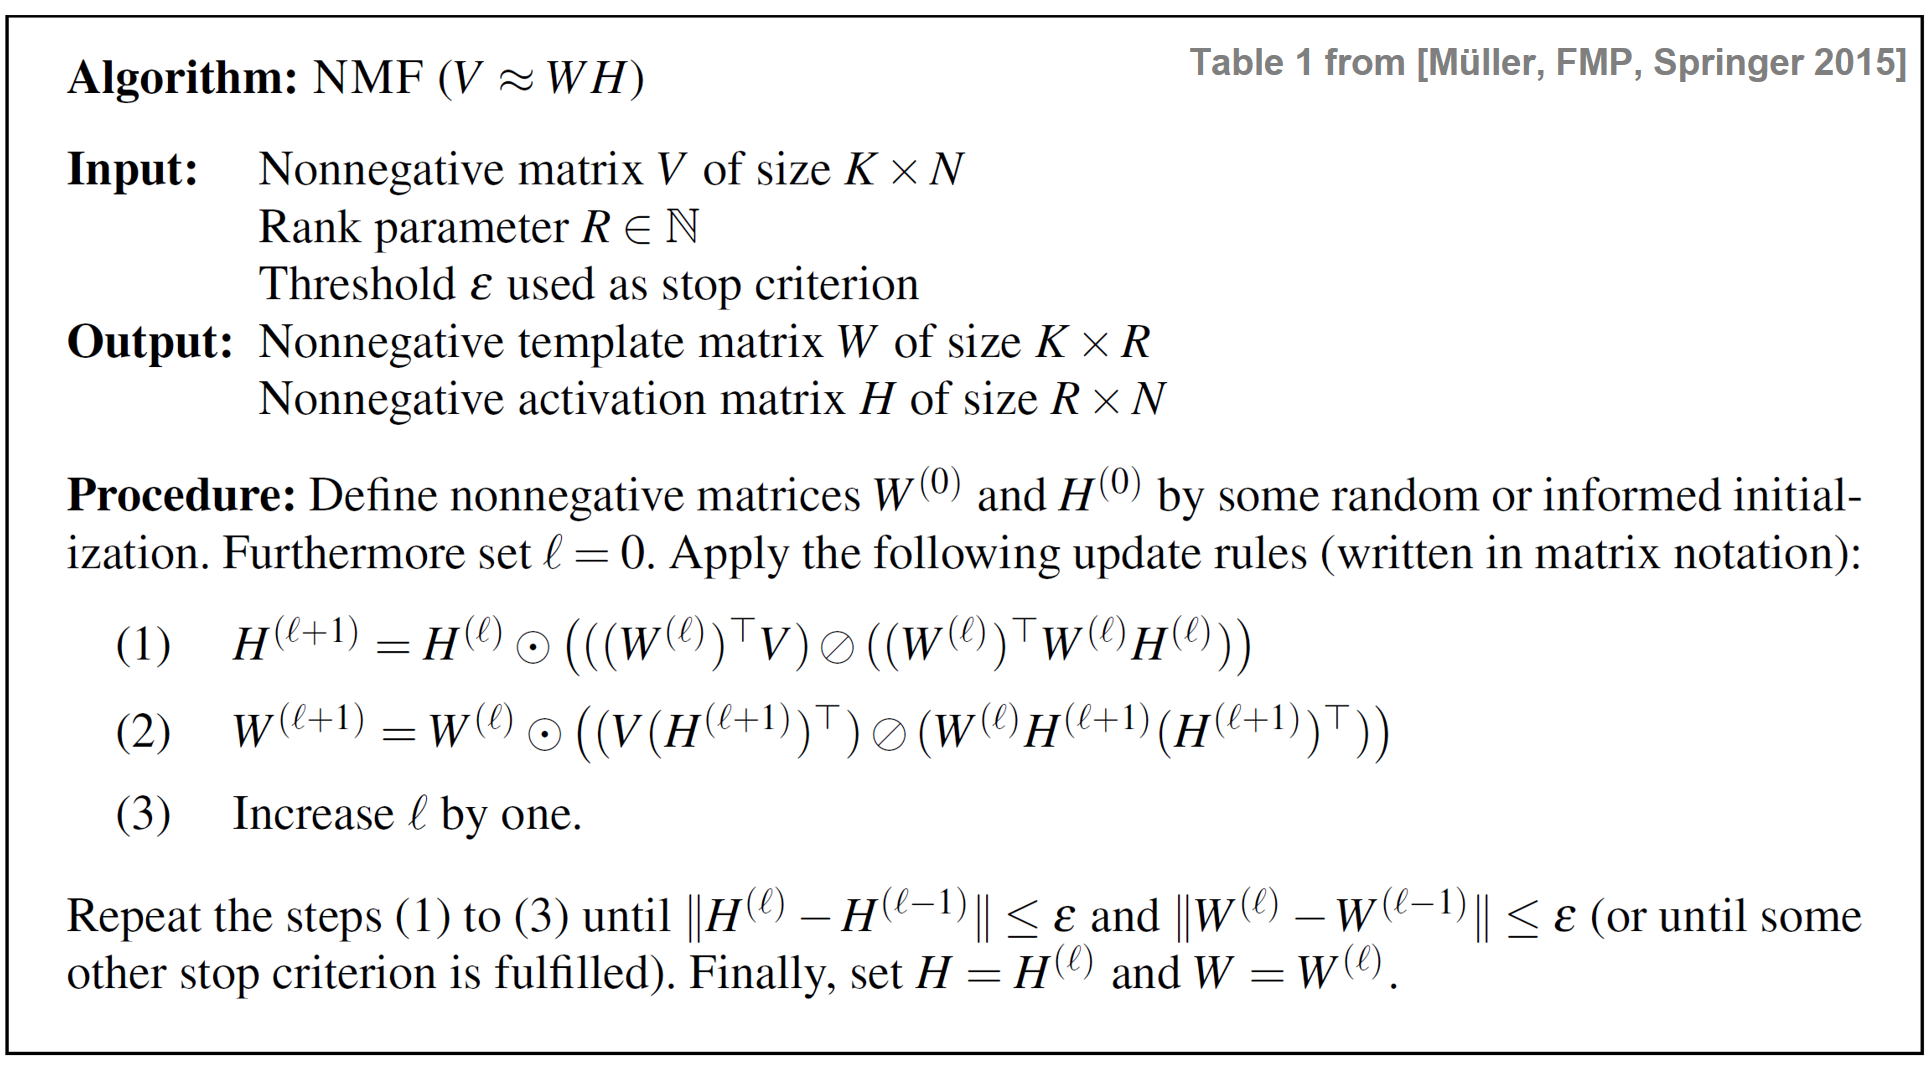

In [6]:
Image(path_img+"FMP_C8_T01.png", width="600px")

- 곱셈(multiplicative) 업데이트 규칙은 몇가지 눈에 띄는 점이 있다.
    * 첫 번째로 행렬 시퀀스 $W^{(0)},W^{(1)},W^{(2)},\ldots$ 및 $H^{(0)},H^{(1)},H^{(2)},\ldots$는 수렴한다. $W^{(\infty)}$ 및 $H^{(\infty)}$로 극한 행렬을 나타내면, 정상성(stationarity) 속성은 이러한 행렬이 거리 함수 $\|V-WH\| ^2$읠 로컬 최소값을 형성함을 의미한다..
    * 둘째, 구현하기가 매우 쉽다.
    * 셋째, 실제로는 수렴이 다른 많은 방법에 비해 상대적으로 빠른 것으로 나타난다.
    * 넷째, 비음수 제약 조건이 자동으로 적용된다.

- 실제로 비음수 행렬 $V$, $W^{(0)}$ 및 $H^{(0)}$부터 시작하여 위 표의 방정식 (1) 및 (2)의 모든 항목도 음수가 아니다. 모든 연산은 곱셈 또는 나눗셈이므로 행렬 $W^{(\ell)}$ 및 $H^{(\ell)}$도 반복 전체에서 음수가 아닌 상태로 유지된다.

- 지정된 정지 기준(stop criterion)이 충족될 때까지 반복이 수행된다. 예를 들어, 일부 지정 매개변수 $L\in\mathbb{N}$에 대해 특정 수의 반복 $\ell=0,1,2,\ldots, L$을 수행할 수 있다. 또 다른 정지 기준으로, 연속적으로 계산된 두 개의 템플릿 행렬과 활성화 행렬 사이의 거리를 볼 수 있다. 임계값 $\varepsilon>0$을 지정하면 $\|H^{(\ell+1)}-H^{(\ell)}\|^2\leq \varepsilon$ 및 $\|W^{(\ell+1)}-W^{(\ell)}\|^2\leq \varepsilon$일 때 반복이 중지될 수 있다.

## 구현

- 다음 코드 셀에서는 위에서 설명한 NMF 절차의 기본 구현을 제공한다. 다음은 몇 가지 중요한 참고 사항이다.
    * 모든 연산은 행렬 기반 연산을 사용하여 수행된다.
    * 0으로 나누는 것을 방지하기 위해 곱셈 업데이트 규칙의 분모에 작은 값(기계 엡실론)이 추가된다.
    * 분해 $V\approx WH$에서 각각 $W$ 및 $H$의 열과 행에 대해 자유도가 있다. 예를 들어, $W$ 열을 인수 $\alpha\in\mathbb{R}$로 나누고 $WH$ 곱을 변경하지 않고 $H$의 해당 행을 같은 인수로 곱할 수 있다. 다음 코드에서 `norm=True` 매개변수를 설정하면 이 사실을 사용하여 최종 템플릿 행렬 $W$의 모든 열이 최대 노름(norm)과 관련하여 정규화되도록 한다.
    * 지정하지 않으면 행렬 $W$ 및 $H$가 임의로 초기화된다.

In [7]:
def nmf(V, R, thresh=0.001, L=1000, W=None, H=None, norm=False, report=False):
    """NMF algorithm with Euclidean distance

    Args:
        V (np.ndarray): Nonnegative matrix of size K x N
        R (int): Rank parameter
        thresh (float): Threshold used as stop criterion (Default value = 0.001)
        L (int): Maximal number of iteration (Default value = 1000)
        W (np.ndarray): Nonnegative matrix of size K x R used for initialization (Default value = None)
        H (np.ndarray): Nonnegative matrix of size R x N used for initialization (Default value = None)
        norm (bool): Applies max-normalization of columns of final W (Default value = False)
        report (bool): Reports errors during runtime (Default value = False)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R
        H (np.ndarray): Nonnegative matrix of size R x N
        V_approx (np.ndarray): Nonnegative matrix W*H of size K x N
        V_approx_err (float): Error between V and V_approx
        H_W_error (np.ndarray): History of errors of subsequent H and W matrices
    """
    K = V.shape[0]
    N = V.shape[1]
    if W is None:
        W = np.random.rand(K, R)
    if H is None:
        H = np.random.rand(R, N)
    V = V.astype(np.float64)
    W = W.astype(np.float64)
    H = H.astype(np.float64)
    H_W_error = np.zeros((2, L))
    ell = 1
    below_thresh = False
    eps_machine = np.finfo(np.float32).eps
    while not below_thresh and ell <= L:
        H_ell = H
        W_ell = W
        H = H * (W.transpose().dot(V) / (W.transpose().dot(W).dot(H) + eps_machine))
        W = W * (V.dot(H.transpose()) / (W.dot(H).dot(H.transpose()) + eps_machine))

        H_error = np.linalg.norm(H-H_ell, ord=2)
        W_error = np.linalg.norm(W - W_ell, ord=2)
        H_W_error[:, ell-1] = [H_error, W_error]
        if report:
            print('Iteration: ', ell, ', H_error: ', H_error, ', W_error: ', W_error)
        if H_error < thresh and W_error < thresh:
            below_thresh = True
            H_W_error = H_W_error[:, 0:ell]
        ell += 1
    if norm:
        for r in range(R):
            v_max = np.max(W[:, r])
            if v_max > 0:
                W[:, r] = W[:, r] / v_max
                H[r, :] = H[r, :] * v_max
    V_approx = W.dot(H)
    V_approx_err = np.linalg.norm(V-V_approx, ord=2)
    return W, H, V_approx, V_approx_err, H_W_error

- $K=4$ 및 $N=8$의 작은 예제 $V \in \mathbb{R}_{\ge 0}^{K \times N}$를 통해 NMF 절차를 본다. 순위(rank) 매개변수는 $R=2$로 설정된다.

Matrix V and randomly initialized matrices W and H


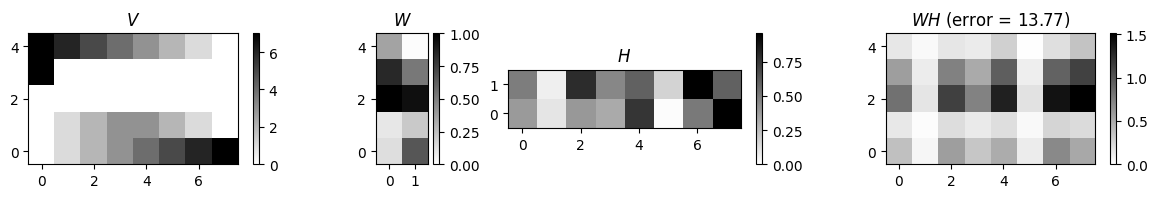

Matrix V and matrices W and H after training


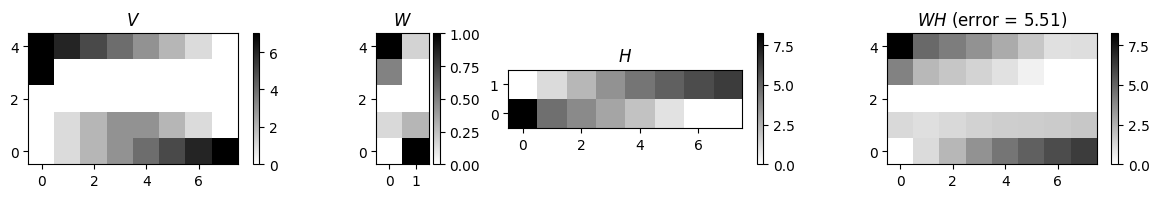

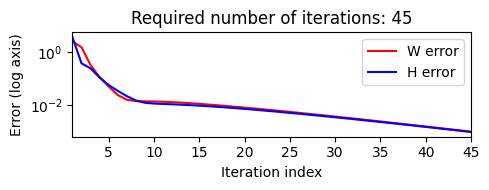

In [8]:
def plot_nmf(V, W, H, V_approx, error, figsize=(10,2), aspect='auto', wr=[1, 0.5, 1, 1]): 
    fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': wr},
                           figsize=figsize)    
    cmap = 'gray_r'
    im = ax[0].imshow(V, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V)])
    ax[0].set_title(r'$V$')
    plt.sca(ax[0])
    plt.colorbar(im)   
    im = ax[1].imshow(W, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(W)])
    ax[1].set_title(r'$W$')
    plt.sca(ax[1])
    plt.colorbar(im)
    im = ax[2].imshow(H, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(H)])
    ax[2].set_title(r'$H$')
    plt.sca(ax[2])    
    plt.colorbar(im)
    im = ax[3].imshow(V_approx, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V_approx)])
    ax[3].set_title(r'$WH$ (error = %0.2f)'%error)
    plt.sca(ax[3])    
    plt.colorbar(im)
    plt.tight_layout() 
    plt.show() 
    
V = np.array([ 
    [0, 1, 2, 3, 4, 5, 6, 7], 
    [0, 1, 2, 3, 3, 2, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0], 
    [7, 0, 0, 0, 0, 0, 0, 0], 
    [7, 6, 5, 4, 3, 2, 1, 0]    
             ],dtype=float)

K = V.shape[0]
N = V.shape[1]
R = 2
thresh = 0.001
L = 100

W_init =  np.random.rand(K,R) 
W_init = W_init/np.max(W_init)
H_init = np.random.rand(R,N)    

print('Matrix V and randomly initialized matrices W and H')
V_approx = W_init.dot(H_init)
error = np.linalg.norm(V-V_approx, ord=2)
plot_nmf(V, W_init, H_init, V_approx, error, figsize=(12,2), 
         aspect='equal', wr=[1, 0.3, 1, 1])

print('Matrix V and matrices W and H after training')
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
                                   L=L, W=W_init, H=H_init, norm=1, report=0)
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), 
         aspect='equal', wr=[1, 0.3, 1, 1])

plt.figure(figsize=(5,2))
num_iter = H_W_error.shape[1]
plt.plot(np.arange(num_iter)+1, H_W_error[0,:], 'r', label='W error')
plt.plot(np.arange(num_iter)+1, H_W_error[1,:], 'b', label='H error')
plt.yscale('log')
plt.xlabel('Iteration index')
plt.ylabel('Error (log axis)')
plt.title('Required number of iterations: %d'%num_iter)
plt.xlim([1, num_iter])
plt.legend()
plt.tight_layout()

### 순위(rank) 매개변수에 따라

- 마지막 예에서 NMF가 학습한 두 개의 템플릿($W$ 열)은 (계수 값 측면에서) 지배적인 $V$의 첫 번째 열과 마지막 열 각각의 특성을 캡처한다.
- 예제는 $V$와 학습된 곱 $WH$ 사이의 오류가 여전히 클 수 있음을 보여준다. 이는 NMF 알고리즘이 전역 최적으로 수렴하는 경우에도 같을 수 있다. 
- 다음 예에서는 다른 매개변수 $R$를 사용한 예를 보여준다. $R=1$를 사용하는 것은 전체 행렬 $V$를 "설명"하는 데 단일 템플릿 벡터만 사용되는 가장 제한적인 경우이다. $R$를 늘리면 $V\approx WH$의 더 나은 근사값을 얻는다. 그러나 행렬 $W$ 및 $H$는 덜 구조화되어 해석하기 더 어려워진다.

R = 1


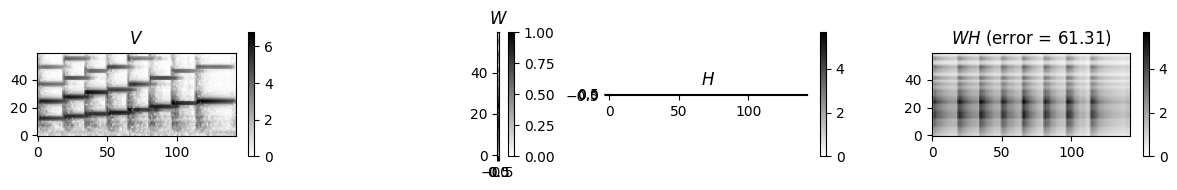

R = 2


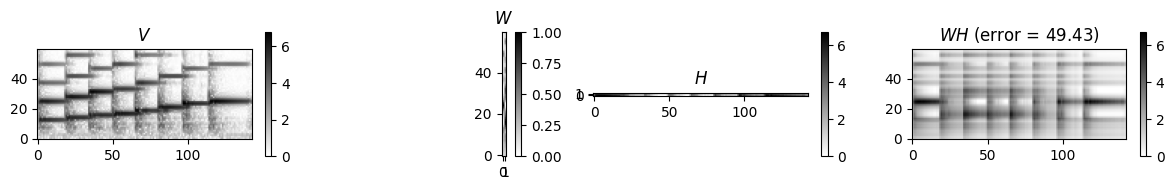

R = 3


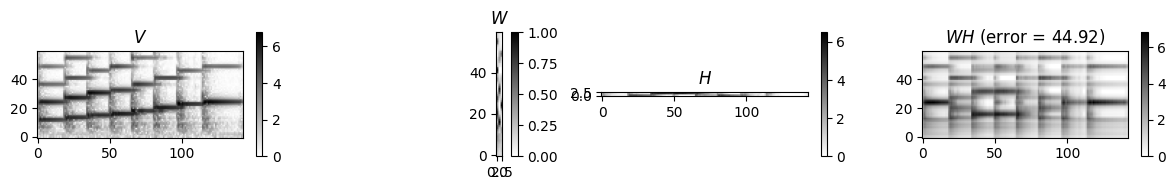

R = 4


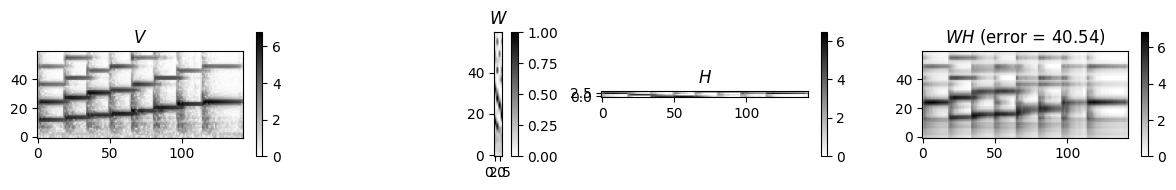

In [12]:
thresh = 0.00001
L = 100
R_set = np.array([1, 2, 3, 4])
for R in R_set: 
    print('R = %d'%R)
    W_init =  np.random.rand(K,R) 
    W_init = W_init/np.max(W_init)
    H_init = np.random.rand(R,N)    
    W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
                                       L=L, W=W_init, H=H_init, norm=1, report=0)
    plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), 
             aspect='equal', wr=[1, 0.7, 1, 1])

## 예시: C-Major Scale

- 실제 오디오 신호의 **크기(magnitude) 스펙트로그램**에 NMF를 적용해보자. 예로 $\mathrm{C4}$ ($261.6~\mathrm{Hz}$)로 시작하여 $\mathrm{C5}$ ($523.2~\mathrm{Hz}$).로 끝나는 C-major scale 녹음을 본다.

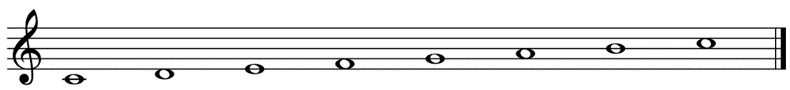

In [14]:
Image(path_img+"FMP_C8_Audio_C-major-scale.png", width="400px")

- 입력 행렬 $V$로 STFT의 저주파 부분만 고려한다. 첫 번째 실험에서는 $R=7$를 사용한다.

Matrix V and randomly initialized matrices W and H


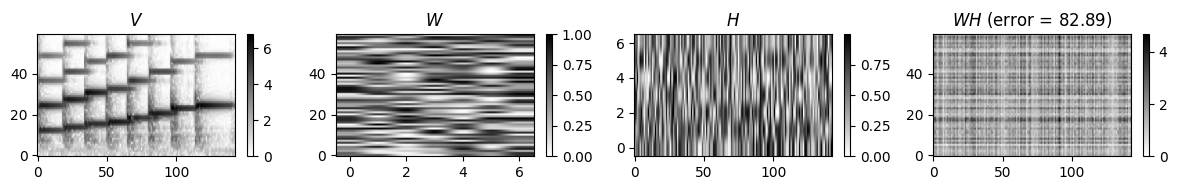

Matrix V and matrices W and H after training


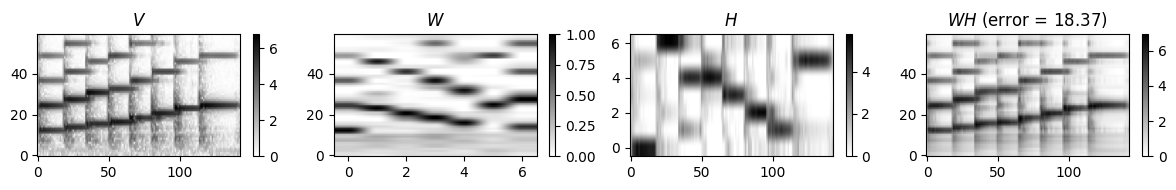

In [15]:
fn_wav = 'FMP_C3_F08_C-major-scale.wav'
x, Fs = librosa.load(path_data+fn_wav)
N, H = 1024, 512
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', center=True, pad_mode='constant')
V = np.log(1 + 10 * np.abs(X))
V = V[0:60,:]

K = V.shape[0]
N = V.shape[1]
R = 7
thresh = 0.0001
L = 200

W_init =  np.random.rand(K,R) 
W_init = W_init/np.max(W_init)
H_init = np.random.rand(R,N)    
V_approx = W_init.dot(H_init)
error = np.linalg.norm(V-V_approx, ord=2)
print('Matrix V and randomly initialized matrices W and H')
plot_nmf(V, W_init, H_init, V_approx, error, figsize=(12,2), wr=[1, 1, 1, 1])

W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
                                              L=L, W=W_init, H=H_init, norm=1, report=0)
print('Matrix V and matrices W and H after training')
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), wr=[1, 1, 1, 1])

- 이 그림은 좋은 전체 근사치 $V\approx WH$를 얻을 수 있음을 의미한다. $W$로 인코딩된 7개의 템플릿은 첫 번째(C4)와 마지막 음(C5)이 템플릿을 공유하는 C장음계의 원형 스펙트럼 벡터에 해당한다.
- 이 예는 또한 $W$의 템플릿 열 순서(및 $H$의 활성화 행과 동일)에 의미 체계가 없음을 보여준다. 실제로 NMF 분해는 어떤 순서도 선호하지 않는다.

- 순위 매개변수를 늘리면 일반적으로 다음 그림과 같이 더 나은 전체 근사 품질을 얻는다. 예를 들어, 시작 관련(수직) 구조와 같은 세부 사항은 작은 $R$를 사용하는 것에 비해 더 잘 재구성된다. 단, $W$와 $H$의 음악적 해석이 손실될 수 있다는 단점이 있다.

Matrix V and matrices W and H after training using R = 4


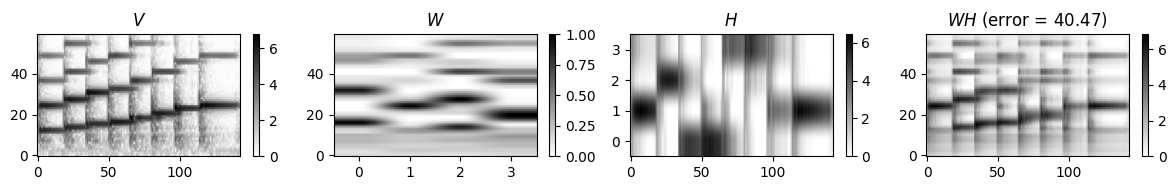

Matrix V and matrices W and H after training using R = 10


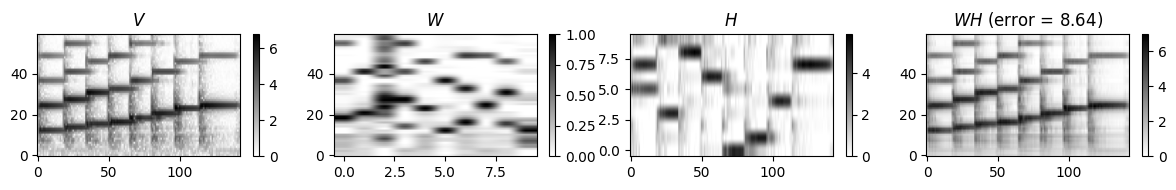

Matrix V and matrices W and H after training using R = 15


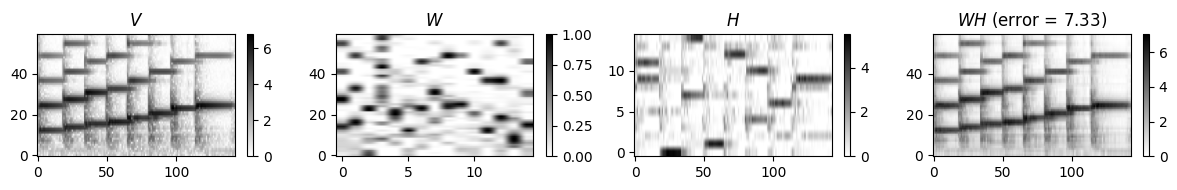

In [16]:
R = 4
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, L=L, norm=1)
print('Matrix V and matrices W and H after training using R = %d'%R)
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), wr=[1, 1, 1, 1])

R = 10
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, L=L, norm=1)
print('Matrix V and matrices W and H after training using R = %d'%R)
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), wr=[1, 1, 1, 1])

R = 15
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, L=L, norm=1)
print('Matrix V and matrices W and H after training using R = %d'%R)
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), wr=[1, 1, 1, 1])

# NMF-Based Spectrogram Factorization

- 위에서 NMF 알고리즘을 사용하여 두 비음행렬의 곱으로 주어진 오디오 녹음의 크기 스펙트로그램을 근사화하는 방법을 살펴보았다. 직관적으로 첫 번째 매트릭스는 녹음에서 발생하는 다양한 스펙트럼 패턴(음악 피치)을 나타내고 두 번째 매트릭스는 이러한 스펙트럼 패턴이 활성화되는 시점을 나타낸다. 일반적으로 NMF에서 얻은 분해는 직접적인 의미론적 해석을 가진다. 
- 다음에서는 오디오 신호를 음악적으로 의미 있는 사운드 이벤트로 분해하기 위해 음악 정보(예: 악보 표현으로 지정된 대로)를 연속적으로 통합하는 방법을 보여준다.

- 시간-주파수 패턴에 해당하는 피아노에서 연주되는 개별 음을 생각해보자. 직관적으로 이 패턴은 피치-종속적인 고조파 구조와 시간에 따른 소리의 볼륨을 설명하는 시간-종속적 가중치가 있는 스펙트럼 벡터로 설명할 수 있다. 여러 음표를 연주하면 결과 오디오 녹음이 개별 음표에 해당하는 사운드 이벤트의 중첩으로 간주될 수 있다. 
- 주어진 음악 신호 $x$를 분해하기 위해 STFT $\mathcal{X}$의 크기에 NMF를 적용한다. 보다 정확하게는 조옮김(transposed) 버전을 사용하여  $(K\times N)$ 비음행렬 $V:=|\mathcal{X}|^\top$를 얻는다.


- 분해 $V \approx W \cdot H$에서 템플릿 행렬 $W$는 피치-종속 스펙트럼 벡터의 구조를 선택하는 반면 활성화 행렬 $H$는 각각의 벡터가 언제 얼마나 강력하게 각 벡터가 활성화되는지 인코딩한다.
- 이런 식으로 행렬 $H$는 음표 템플릿에 대한 일종의 가중 피아노 롤 표현을 생성한다. 이러한 종류의 해석을 위해 순위 매개변수 $R$는 음악 작품에서 발생하는 서로 다른 피치의 수에 해당해야 한다.

## 예시 (Chopin)

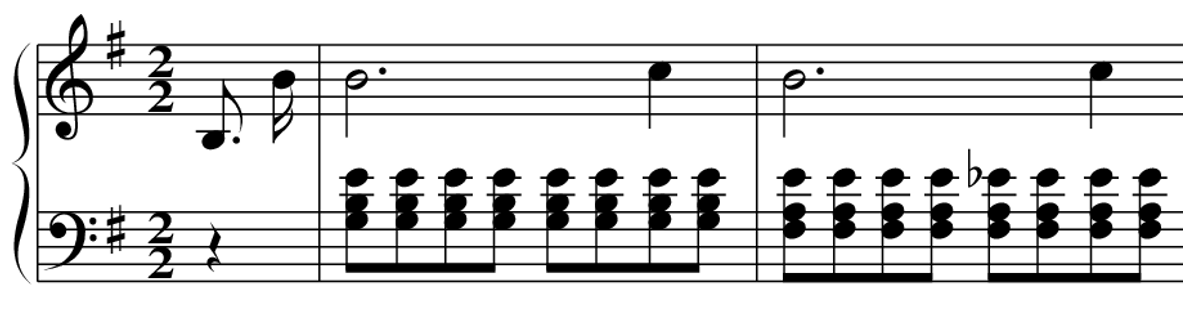

In [17]:
Image(path_img+"FMP_C8_F21a.png", width="320px")

In [18]:
Audio(path_data+"FMP_C8_F27_Chopin_Op028-04_minor.wav")

- NMF 알고리즘에 대한 입력으로 다음 코드 셀에서 계산된 로그적으로 압축된 크기 스펙트로그램을 사용한다.

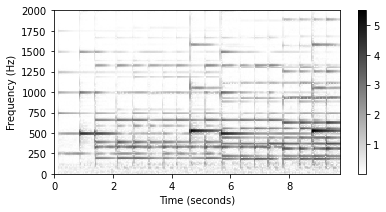

In [21]:
#fn_wav = 'FMP_C8_Audio_Chopin_Op028-04_SMD_beginning.wav'
fn_wav = "FMP_C8_F27_Chopin_Op028-04_minor.wav"
x, Fs = librosa.load(path_data+fn_wav)
N_fft = 2048
H_fft = 1024
X = librosa.stft(x, n_fft=N_fft, hop_length=H_fft)
V = np.log(1 + np.abs(X))
#V = np.abs(X)
freq_max = 2000

plot_matrix(V, Fs=Fs/H_fft, Fs_F=N_fft/Fs)
plt.ylim([0, freq_max]);

## 랜덤 초기화 NMF (Random Initialization)

- 이제 임의로 초기화된 행렬 $W^{(0)}$ 및 $H^{(0)}$를 반복적으로 업데이트하여 크기 스펙트로그램에 NMF 알고리즘을 적용한다. 다음 그림에는 초기화된 템플릿과 활성화 매트릭스 그리고 학습된 것 모두 표시되어 있다. 이 예에서 순위 매개변수는 $R=8$로 설정되어 음악 예에서 발생하는 8개의 서로 다른 음악 피치 각각에 대해 하나의 템플릿을 허용한다.

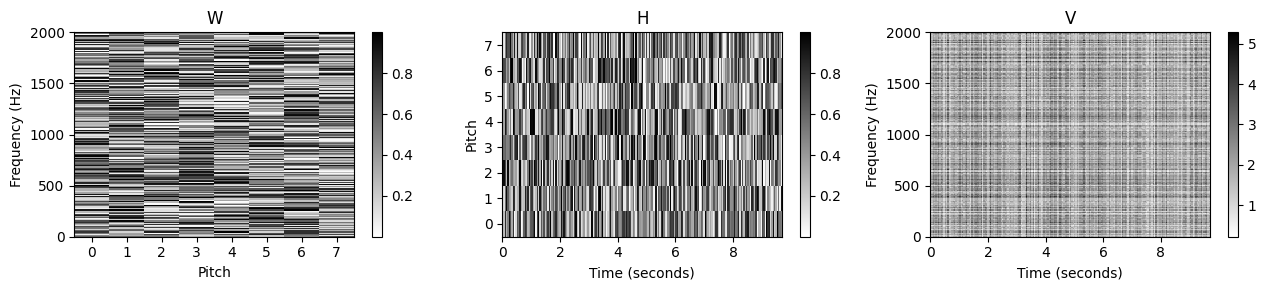

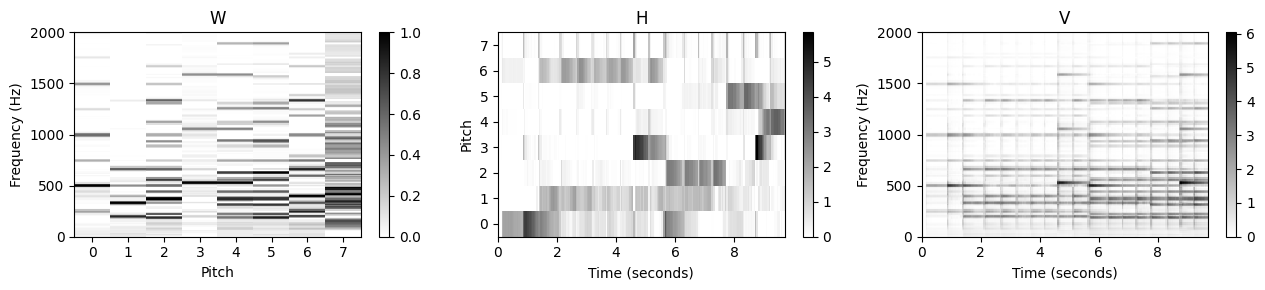

In [25]:
def plot_nmf_factors(W, H, V, Fs, N_fft, H_fft, freq_max, label_pitch=None,
                     title_W='W', title_H='H', title_V='V', figsize=(13, 3)):
    """Plots the factors of an NMF-based spectral decomposition

    Args:
        W: Template matrix
        H: Activation matrix
        V: Reconstructed input matrix
        Fs: Sampling frequency
        N_fft: FFT length
        H_fft: Hopsize
        freq_max: Maximum frequency to be plotted
        label_pitch: Labels for the different pitches (Default value = None)
        title_W: Title for imshow of matrix W (Default value = 'W')
        title_H: Title for imshow of matrix H (Default value = 'H')
        title_V: Title for imshow of matrix V (Default value = 'V')
        figsize: Size of the figure (Default value = (13, 3))
    """
    R = W.shape[1]
    N = H.shape[1]
    # cmap = libfmp.b.compressed_gray_cmap(alpha=5)
    cmap = 'gray_r'
    dur_sec = (N-1) * H_fft / Fs
    if label_pitch is None:
        label_pitch = np.arange(R)

    plt.figure(figsize=figsize)
    plt.subplot(131)
    plt.imshow(W, cmap=cmap, origin='lower', aspect='auto', extent=[0, R, 0, Fs/2], interpolation='nearest')
    plt.ylim([0, freq_max])
    plt.colorbar()
    plt.xticks(np.arange(R) + 0.5, label_pitch)
    plt.xlabel('Pitch')
    plt.ylabel('Frequency (Hz)')
    plt.title(title_W)

    plt.subplot(132)
    plt.imshow(H, cmap=cmap, origin='lower', aspect='auto', extent=[0, dur_sec, 0, R], interpolation='nearest')
    plt.colorbar()
    plt.yticks(np.arange(R) + 0.5, label_pitch)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Pitch')
    plt.title(title_H)

    plt.subplot(133)
    plt.imshow(V, cmap=cmap, origin='lower', aspect='auto', extent=[0, dur_sec, 0, Fs/2], interpolation='nearest')
    plt.ylim([0, freq_max])
    plt.colorbar()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title_V)

    plt.tight_layout()
    plt.show()

K = V.shape[0]
N = V.shape[1]
R = 8

W_init = np.random.rand(K,R)
H_init = np.random.rand(R,N)

W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, W=W_init, H=H_init, L=200, norm=True)
#label_pitch=['54', '55', '57', '59', '63', '64', '71', '72']
plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max)
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max)               

- 이 예에서 알 수 있듯이 이 접근 방식에는 다양한 문제가 있다. 학습된 템플릿 행렬 $W$를 보면 주어진 템플릿이 어떤 소리나 피치에 해당하는지 명확하지 않다. 템플릿 벡터 중 일부만이 명확한 화성 구조를 나타내지만 대부분의 템플릿은 개별 음이 아닌 음의 혼합에 해당하는 것으로 보인다. 이것은 또한 악보의 피아노 롤 표현과 거의 연관될 수 없는 $H$의 활성화 패턴으로 표시된다.
- 요약하면, 원래 행렬 $V$가 잘 근사될 수 있지만, 단순히 임의 초기화에 기반한 표준 NMF 접근 방식을 적용하면 명확한 음악적 의미가 결여된 분해가 생성되는 경우가 많다.

## 피치가 알려진 템플릿 제약 (Pitch-Informed Template Constraints)

- 위의 문제를 극복하기 위한 한 가지 중요한 아이디어는 $W$ 및 $H$에 적절한 제약을 추가하는 것이다. 이러한 맥락에서 곱셈 업데이트 규칙은 큰 이점이 있다. 곱셈의 경우 전체 학습 과정에서 값이 0인 항목이 그대로 유지된다. 이 속성 덕분에 초기화 단계에서 적절한 항목을 0으로 설정하여 $W$ 및 $H$에 특정 구조를 적용할 수 있다. 이 수정된 초기화 방법을 사용할 수 있다.

- 이제 이 전략을 적용하여 $W$의 템플릿에서 고조파 구조를 강화한다. 피치 $p$를 각 템플릿 벡터에 할당한 후 중심 주파수 $F_\mathrm{pitch}(p) = 2^{(p-69)/12} \cdot 440$를 기본 주파수의 추정치로 사용할 수 있다. 이로부터 중심 주파수의 정수배에 위치한 고조파의 대략적인 위치를 도출할 수 있다. 정확한 주파수를 알 수 없기 때문에 이러한 위치 주변의 이웃은 나머지 항목을 0으로 설정하면서 템플릿에서 0이 아닌 값으로 초기화될 수 있다.

In [24]:
def pitch_from_annotation(annotation):
    """Extract set of occurring pitches from annotation

    Args:
        annotation (list): Annotation data

    Returns:
        pitch_set (np.ndarray): Set of occurring pitches
    """
    pitch_all = np.array([c[2] for c in annotation])
    pitch_set = np.unique(pitch_all)
    return pitch_set


def template_pitch(K, pitch, freq_res, tol_pitch=0.05):
    """Defines spectral template for a given pitch

    Args:
        K (int): Number of frequency points
        pitch (float): Fundamental pitch
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        template (np.ndarray): Nonnegative template vector of size K
    """
    max_freq = K * freq_res
    pitch_freq = 2**((pitch - 69) / 12) * 440
    max_order = int(np.ceil(max_freq / ((1 - tol_pitch) * pitch_freq)))
    template = np.zeros(K)
    for m in range(1, max_order + 1):
        min_idx = max(0, int((1 - tol_pitch) * m * pitch_freq / freq_res))
        max_idx = min(K-1, int((1 + tol_pitch) * m * pitch_freq / freq_res))
        template[min_idx:max_idx+1] = 1 / m
    return template
        
    
def init_nmf_template_pitch(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix for a given set of pitches

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, R))
    for r in range(R):
        W[:, r] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W

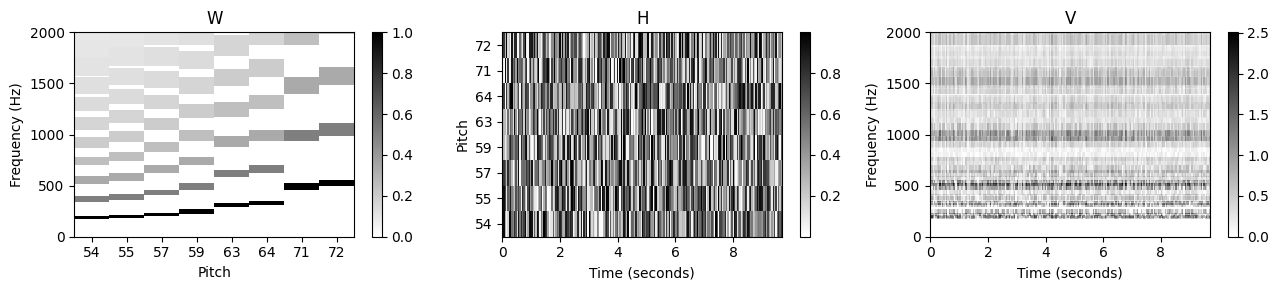

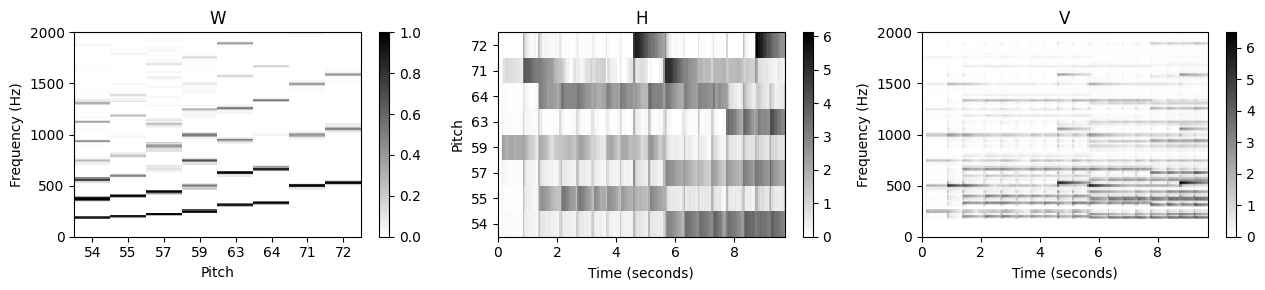

In [29]:
def csv_to_list(csv):
    df = pd.read_csv(csv, header=0, sep=';', keep_default_na=False)
    score = []
    for i, (start, duration, pitch, velocity, label) in df.iterrows():
        score.append([start, duration, pitch, velocity, label])
    return score


fn_ann = 'FMP_C8_Audio_Chopin_Op028-04_SMD_beginning.csv'
annotation = csv_to_list(path_data+fn_ann)
pitch_set = pitch_from_annotation(annotation)

K = V.shape[0]
N = V.shape[1]
R = pitch_set.shape[0]
freq_res = Fs / N_fft
W_init = init_nmf_template_pitch(K, pitch_set, freq_res, tol_pitch=0.05)
H_init = np.random.rand(R,N)

W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, W=W_init, H=H_init, L=100, norm=True)
plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max, label_pitch=pitch_set)
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max, label_pitch=pitch_set)    

- 곱셈 업데이트 규칙에 기반한 학습 프로세스는 고조파 구조를 유지할 뿐만 아니라 이를 더욱 세분화한다. 동시에 활성화 매트릭스는 연주된 음의 존재와 강도를 아주 잘 반영한다. 활성 매트릭스의 수직 구조는 노트 온셋의 트랜지언트와 관련된 짧은 시간 에너지 폭발의 결과이다. 이러한 구조는 화성 정보를 제공하는 템플릿에 의해 잘 반영되지 않으며 모든 템플릿의 중첩으로 "합성"(synthesized)된다.

## 악보가 알려진 템플릿 제약 (Score-Informed Activation Constraints)

- 추가 사전 지식이 있는 경우 이를 활용하여 분해 프로세스를 더욱 안정화할 수 있다. 이런 맥락에서 악보가 특히 중요하다. 개략적인 수준에서 악보에서 어떤 악기가 연주되고 있는지 또는 음악이 진행되는 동안 어떤 피치가 발생하는지와 같은 **전역적 정보**를 추출할 수 있다.

- 이 예에서는 이러한 정보를 사용하여 템플릿 수를 자동으로 $R=8$로 설정할 수 있다. 또한 격리된 음표의 녹음에서 파생될 수 있는 악기 종속적 고조파 모델을 사용하여 템플릿의 초기화를 개선할 수 있다.
- 보다 미세한 수준에서, 음이 실제로 연주되는 시점에 대한 **로컬 정보**를 활용할 수도 있다. 악보에 의해 지정된 음표 이벤트가 오디오 녹음에서 발생하는 시간 위치에 정렬되어 있다고 가정하면 특정 템플릿이 활성화될 수 있는 시간 제약을 부과할 수 있다.
- 이를 위해 해당 활성화 항목을 1로 설정하여 $H^{(0)}$에서 적합한 영역을 초기화하고, 나머지 항목은 0으로 설정된다. 예를 들어 피치 $p=55$에 해당하는 활성화 항목은 대략 $t=2$에서 $t=7$까지의 시간 간격으로 제한된다(초 단위).

In [30]:
def init_nmf_activation_score(N, annotation, frame_res, tol_note=[0.2, 0.5], pitch_set=None):
    """Initializes activation matrix for given score annotations

    Args:
        N (int): Number of frames
        annotation (list): Annotation data
        frame_res (time): Time resolution
        tol_note (list or np.ndarray): Tolerance (seconds) for beginning and end of a note (Default value = [0.2, 0.5])
        pitch_set (np.ndarray): Set of occurring pitches (Default value = None)

    Returns:
        H (np.ndarray): Nonnegative matrix of size R x N
        pitch_set (np.ndarray): Set of occurring pitches
    """
    note_start = np.array([c[0] for c in annotation])
    note_dur = np.array([c[1] for c in annotation])
    pitch_all = np.array([c[2] for c in annotation])
    if pitch_set is None:
        pitch_set = np.unique(pitch_all)
    R = len(pitch_set)
    H = np.zeros((R, N))
    for i in range(len(note_start)):
        start_idx = max(0, int((note_start[i] - tol_note[0]) / frame_res))
        end_idx = min(N, int((note_start[i] + note_dur[i] + tol_note[1]) / frame_res))
        pitch_idx = np.argwhere(pitch_set == pitch_all[i])
        H[pitch_idx, start_idx:end_idx] = 1
    return H, pitch_set

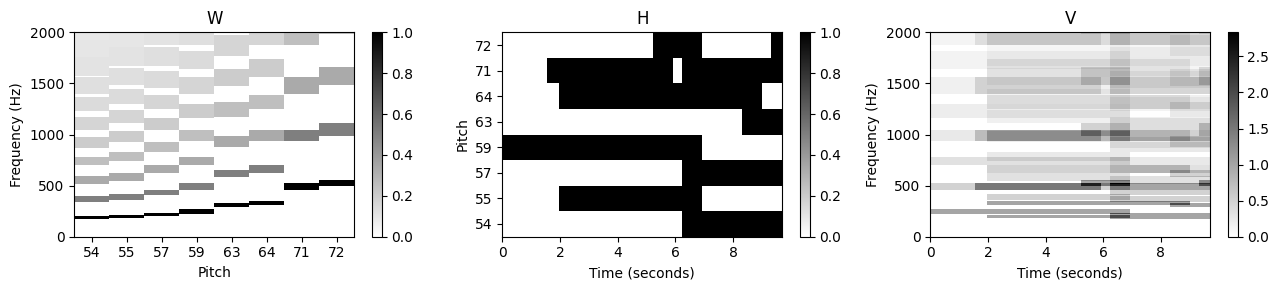

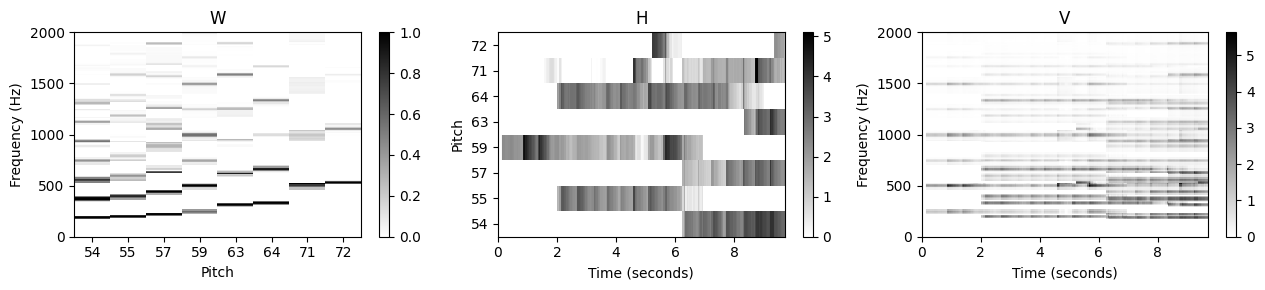

In [32]:
frame_res = H_fft/Fs
H_init, pitch_set = init_nmf_activation_score(N, annotation, frame_res, tol_note=[0.2, 0.5])

W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, W=W_init, H=H_init, L=100, norm=True)
plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max, label_pitch=pitch_set)
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max, label_pitch=pitch_set)

- 결과적으로 활성화 행렬 $H$는 동기화된 악보 정보의 대략적인 피아노 롤 표현으로 해석될 수 있다. 어떤 의미에서 동기화 단계는 NMF 기반 학습 절차에 의해 정제된 첫 번째 근사 분해를 산출하는 것으로 볼 수 있다. 예상대로 활성화 제약 조건을 템플릿 벡터에 대한 제약 조건과 결합하면 결과가 원하는 의미 체계를 더 잘 반영한다는 점에서 분해가 더욱 안정화된다.

## 온셋 (Onset) 모델

- 지금까지 NMF 기반 분해는 신호의 고조파 특성만을 나타냈다. 온셋과 같은 충격 속성을 설명하기 위해 이제 추가 템플릿을 도입하여 NMF 모델을 확장할 수 있는 방법을 보여준다. 
- 첫 번째 아이디어는 모든 피치의 온셋을 공동으로 설명하는 하나의 추가 템플릿을 사용하는 것이다. 그러나 음 시작에 대한 스펙트럼 패턴이 각 피치와 완전히 독립적이지 않을 수 있으므로(피아노의 경우처럼) **각 피치**에 대해 다음과 같은 하나의 추가 **온셋 템플릿**을 사용한다.

- 일반적으로 온셋 템플릿의 스펙트럼 모양을 예측하기는 어렵다. 따라서 고조파 템플릿과 달리 스펙트럼 제약 조건을 적용하지 않고 온셋 템플릿을 균일하게 초기화하고 학습 프로세스가 각각의 모양을 파생하도록 한다. 온셋 템플릿에 대한 의미 있는 스펙트럼 제약 조건을 찾기는 어렵지만 **음 온셋의 단시간(short-time) 특성**으로 인해 활성화 측면에서 상대적으로 **엄격한 시간 제약 조건**을 도입할 수 있다. 

- 이러한 각 위치 주변의 작은 이웃 내에서(동기화 부정확 가능성을 고려하여) 해당 활성화 항목을 하나로 초기화하고 나머지 항목은 모두 0으로 설정한다. 이는 시작 템플릿이 활성화될 수 있는 시점을 강력하게 제한한다.


- 다음 예에서는 템플릿 및 활성화 측면에서 초기화와 함께 확장된 NMF 모델을 사용한다.

In [37]:
def init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix with onsets for a given set of pitches

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x (2R) with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, 2*R))
    for r in range(R):
        W[:, 2*r] = 0.1
        W[:, 2*r+1] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W


def init_nmf_activation_score_onset(N, annotation, frame_res, tol_note=[0.2, 0.5], tol_onset=[0.3, 0.1],
                                    pitch_set=None):
    """Initializes activation matrix with onsets for given score annotations

    Args:
        N (int): Number of frames
        annotation (list): Annotation data
        frame_res (float): Time resolution
        tol_note (list or np.ndarray): Tolerance (seconds) for beginning and end of a note (Default value = [0.2, 0.5])
        tol_onset (list or np.ndarray): Tolerance (seconds) for beginning and end of an onset
            (Default value = [0.3, 0.1])
        pitch_set (np.ndarray): Set of occurring pitches (Default value = None)

    Returns:
        H (np.ndarray): Nonnegative matrix of size (2R) x N
        pitch_set (np.ndarray): Set of occurring pitches
        label_pitch (np.ndarray): Pitch labels for the templates
    """
    note_start = np.array([c[0] for c in annotation])
    note_dur = np.array([c[1] for c in annotation])
    pitch_all = np.array([c[2] for c in annotation])
    if pitch_set is None:
        pitch_set = np.unique(pitch_all)
    R = len(pitch_set)
    H = np.zeros((2*R, N))
    for i in range(len(note_start)):
        start_idx = max(0, int((note_start[i] - tol_note[0]) / frame_res))
        end_idx = min(N, int((note_start[i] + note_dur[i] + tol_note[1]) / frame_res))
        start_onset_idx = max(0, int((note_start[i] - tol_onset[0]) / frame_res))
        end_onset_idx = min(N, int((note_start[i] + tol_onset[1]) / frame_res))
        pitch_idx = np.argwhere(pitch_set == pitch_all[i])
        H[2*pitch_idx, start_onset_idx:end_onset_idx] = 1
        H[2*pitch_idx+1, start_idx:end_idx] = 1
    label_pitch = np.zeros(2*len(pitch_set),  dtype=int)
    for k in range(len(pitch_set)):
        label_pitch[2*k] = pitch_set[k]
        label_pitch[2*k+1] = pitch_set[k]
    return H, pitch_set, label_pitch

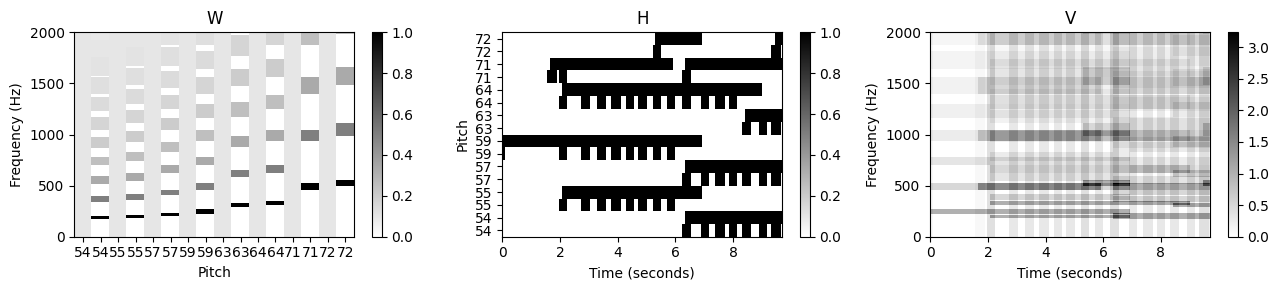

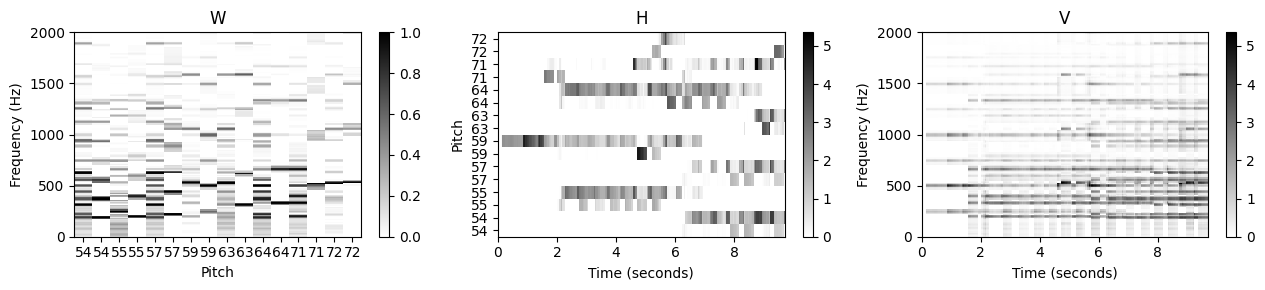

In [38]:
H_init, pitch_set, label_pitch = init_nmf_activation_score_onset(N, annotation, frame_res, 
                                                    tol_note=[0.1, 0.5], tol_onset=[0.2, 0.1])
W_init = init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05)

W, H, V_approx, V_approx_err, H_W_error = nmf(V, 2*R, W=W_init, H=H_init, L=100, norm=True)
plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch )
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch )

- 그림과 같이 학습된 **고조파(harmonic) 템플릿**은 이전의 분해에 비해 훨씬 깔끔한 고조파 구조를 가진다. 그 이유는 대부분의 트랜지언트 광대역 에너지가 이제 **온셋 템플릿**에 의해 포착되기 때문이다.
- 또한 대부분의 온셋 템플릿에 대해 음 이벤트 시작 시 충동 같은(impulse-like) 활성화 패턴을 관찰할 수 있다. 이러한 템플릿이 실제로 온셋을 나타냄을 알 수 있다. 온셋 템플릿을 자세히 살펴보면 다양한 스펙트럼 계수에 걸쳐 에너지의 확산을 관찰할 수 있다. 종종 확산(spread)은 기본 주파수와 첫 번째 고조파 주변 지역에 집중된다.

**결론**

- 학습 과정 내내 $W^{(0)}$ 및 $H^{(0)}$에서 **0으로 유지**되는 항목이 없다는 점에서 도입된 제약 조건은 강(hard)하다. 따라서 잠재적인 동기화 부정확성을 설명하고 어느 정도의 유연성을 유지하려면 다소 관대한 제약 조건 영역을 사용해야 한다.

- 특정 계수를 0으로 설정하여 엄격한 제약 조건을 사용하면 표준 NMF에서와 정확히 동일한 **곱셈(multiplicative) 업데이트 규칙**을 사용할 수 있다. 따라서 제한된 절차는 원래 접근 방식의 **구현 용이성(ease of implementation)** 및 **계산 효율성**(**computationcal efficiency**)을 상속한다. 이것은 NMF를 사용하는 가장 유리한 측면 중 하나이다.

# NMF 기반 오디오 분해

- 위에서 악보 주석을 사용하여 **템플릿 행렬**(피치 사용) 및 **활성화 행렬**(음 온셋 위치 및 음 지속 시간 사용)를 제한했다. 그 결과 크기 스펙트럼 $V$가 음악적으로 의미 있는 템플릿 행렬 $W$와 활성화 행렬 $H$로 분해되었다. 특히, 음별(notewise) 활성화 제약 조건은 $H$의 0이 아닌 계수와 악보의 음표 이벤트 사이의 매핑을 생성한다.
- 이제 이 스펙트로그램 분해를 사용하여 특정 음 그룹에 해당하는 오디오 구성 요소를 분리하는 방법을 설명한다. 멜로디 라인, 특정 모티프 또는 반주를 인코딩할 수 있는 이러한 음 그룹은 악보 표현의 적절한 레이블링(labeling)을 통해 지정될 수 있다.

- 쇼팽의 예를 계속한다. 목표는 녹음을 두 가지 구성 요소로 분해하는 것이다. 여기서 한 구성 요소는 하단 오선지의 음(빨간색 상자로 표시된 피아니스트의 왼손이 연주하는 반주)에 해당하고, 다른 구성 요소는 상단 오선지의 음(노란색 상자로 표시된 오른손이 연주하는 멜로디)이다.

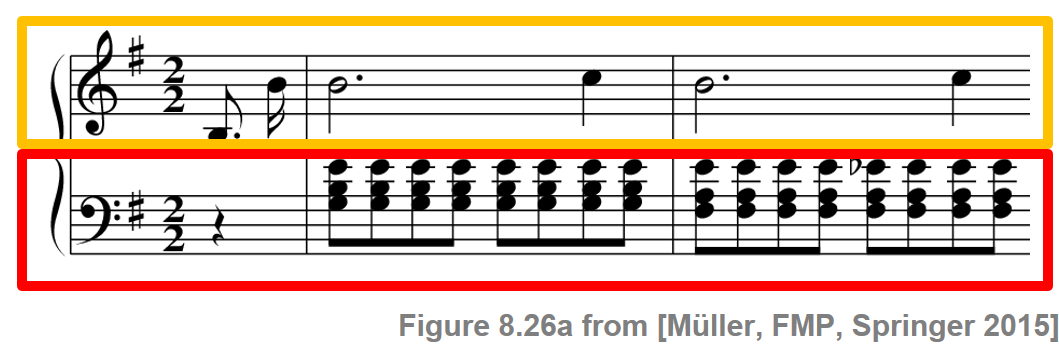

In [42]:
Image(path_img+"FMP_C8_F26a.png", width="320px")

In [43]:
Audio(path_data+"FMP_C8_F27_Chopin_Op028-04_minor.wav")

## Score-Informed Spectrogram Factorization

- NMF 알고리즘에 대한 입력으로 로그적으로 압축된 크기 스펙트로그램을 사용한다. 또한 악보 기반(score-informed) 템플릿 및 활성화 제약 조건(activation constraints)이 있는 온셋 모델을 사용한다. 
- 다음 코드 셀에서는 악보 기반 스펙트로그램 분해 결과를 보여준다.

In [56]:
fn_wav = "FMP_C8_F27_Chopin_Op028-04_minor.wav"

fn_ann = 'FMP_C8_Audio_Chopin_Op028-04_SMD_beginning.csv'

annotation = csv_to_list(path_data+fn_ann)

# Input Spectrogram
x, Fs = librosa.load(path_data+fn_wav)
N_fft = 2048
H_fft = 1024
X = librosa.stft(x, n_fft=N_fft, hop_length=H_fft)
V = np.log(1 + np.abs(X))
#V = np.abs(X)
freq_res = Fs / N_fft
freq_max = 2000
frame_res = H_fft/Fs

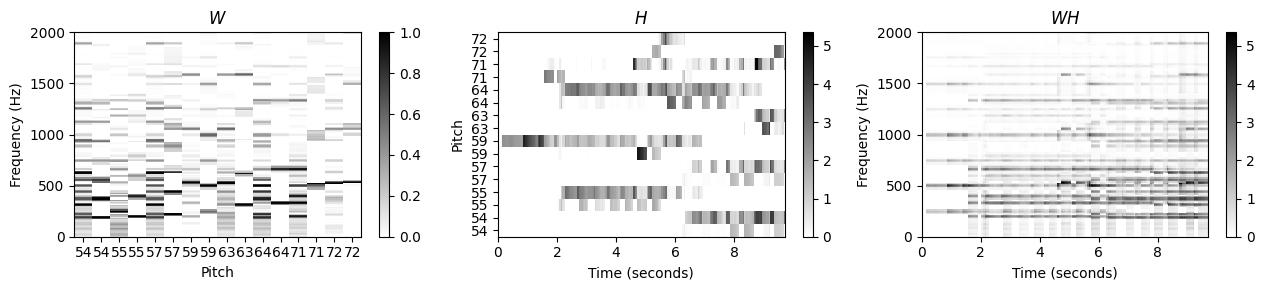

In [57]:
# NMF decomposition using onset model
K = V.shape[0]
N = V.shape[1]
pitch_set = pitch_from_annotation(annotation)
R = pitch_set.shape[0]

H_init, pitch_set, label_pitch = init_nmf_activation_score_onset(N, annotation, frame_res, 
                                                    tol_note=[0.1, 0.5], tol_onset=[0.2, 0.1])
W_init = init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05)

W, H, V_approx, V_approx_err, H_W_error = nmf(V, 2*R, W=W_init, H=H_init, L=100, norm=True)
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch, 
                           title_W=r'$W$', title_H=r'$H$', title_V=r'$WH$')

## 악보 기반 활성화 행렬 분할 (Score-Informed Split of Activation Matrix)

- $H$의 활성화 제약 조건과 악보의 음표 사이의 매핑을 사용하여 $H$를 왼손과 오른손 각각의 활성화인 두 개의 행렬 $H^\mathrm{L}$ 및 $H^\mathrm{R}$로 분할할 수 있다.  이 두 행렬을 템플릿 행렬 $W$와 곱하면 $WH^\mathrm{L}$ 및 $WH^\mathrm{R}$ 두 행렬을 얻는다. 직관적으로 이 두 행렬은 각각 왼손과 오른손에 대해 원하는 구성 요소에 대한 추정 크기 STFT로 간주할 수 있다. 다음 코드 셀에서 활성화 매트릭스의 악보 기반 분할 구현을 제공한다.

In [58]:
def split_annotation_lh_rh(ann):
    """Splitting of the annotation data in left and right hand

    Args:
        ann (list): Annotation data

    Returns:
        ann_lh (list): Annotation data for left hand
        ann_rh (list): Annotation data for right hand
    """
    ann_lh = []
    ann_rh = []
    for a in ann:
        if a[4] == 'lh':
            ann_lh = ann_lh + [a]
        if a[4] == 'rh':
            ann_rh = ann_rh + [a]
    return ann_lh, ann_rh

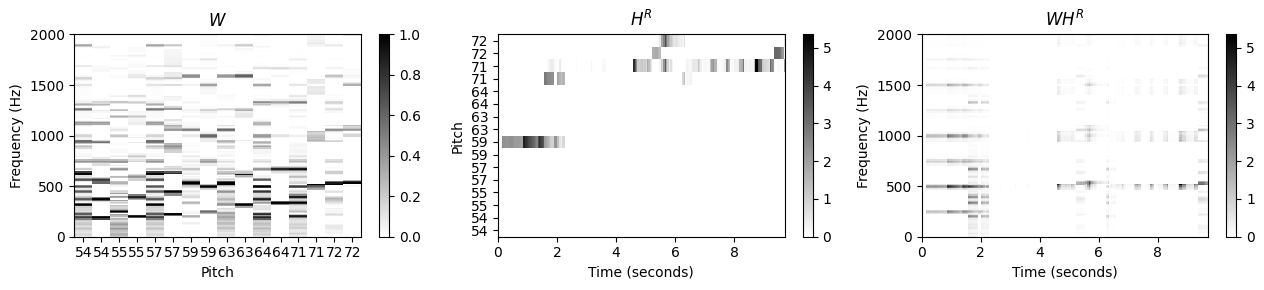

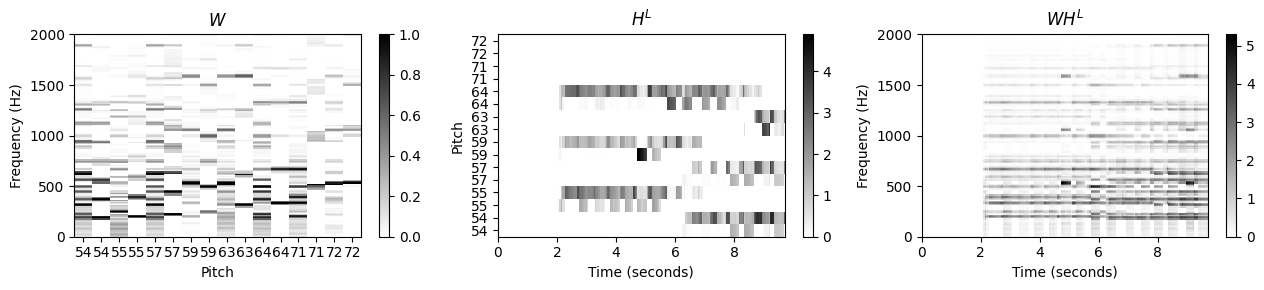

In [59]:
annotation_lh, annotation_rh = split_annotation_lh_rh(annotation)

H_init_L, pitch_set_L, label_pitch_L = init_nmf_activation_score_onset(N, annotation_lh, frame_res, 
                                            tol_note=[0.1, 0.5], tol_onset=[0.2, 0.1], pitch_set=pitch_set)
H_init_R, pitch_set_R, label_pitch_R = init_nmf_activation_score_onset(N, annotation_rh, frame_res, 
                                            tol_note=[0.1, 0.5], tol_onset=[0.2, 0.1], pitch_set=pitch_set)

H_L = H * H_init_L
H_R = H * H_init_R

plot_nmf_factors(W, H_R, W.dot(H_R), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch, 
                           title_W=r'$W$', title_H=r'$H^R$', title_V=r'$WH^R$')
plot_nmf_factors(W, H_L, W.dot(H_L), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch, 
                           title_W=r'$W$', title_H=r'$H^L$', title_V=r'$WH^L$')

## Spectral Masking

- 시간 영역 신호를 얻기 위한 첫 번째 아이디어는 단순히 원래 STFT $\mathcal{X}$의 위상(phase) 정보를 사용하고 **신호 재구성**(**signal reconstruction**) 방법을 적용하여 수정된 STFT 결과를 역으로 구하는 것이다.
- 그러나 NMF 기반 모델은 일반적으로 원래 크기 스펙트로그램(또는 대수적으로 압축된 버전)의 대략적인 근사값만 생성하므로 스펙트럼 뉘앙스 또는 실제 크기가 잘 캡처되지 않을 수 있다. 따라서 이러한 방식으로 재구성된 오디오 구성 요소에는 많은 부산물(artifact)이 포함될 수 있다.
- 이러한 부산물 중 일부는 **마스킹(masking) 기술**을 사용하여 제거하거나 약화시킬 수 있다. 재구성을 위해 $WH^\mathrm{L}$ 및 $WH^\mathrm{R}$를 직접 사용하는 대신 이러한 행렬을 사용하여 두 개의 **소프트 마스크**(soft mask)를 먼저 정의하는 것이 좋다.
    - $M^\mathrm{L} := (W H^\mathrm{L})\oslash (W H + \varepsilon), \\ M^\mathrm{R} := (W H^\mathrm{R})\oslash (W H + \varepsilon)$
    - (여기서 $\oslash$ 연산자는 point-wise 나눗셈을 나타내며, 작은 양수 값 $\varepsilon>0$을 추가하여 0으로 나눔을 방지한다.)


- 그런 다음 두 개의 소프트 마스크를 원래 STFT $\mathcal{X}$에 적용할 수 있다. 역 STFT를 사용하여 왼쪽 및 오른쪽 손의 음표에 대해 각각 원하는 두 개의 시간 영역 구성 요소 신호를 얻는다. 마스킹 기반 접근 방식을 사용하면 NMF 분해 요인에 의해 직접 캡처되지 않더라도 원본 녹음의 많은 스펙트럼 세부 정보가 보존된다. 이는 음향적으로 더 좋은 결과를 종종 낳는다. 단, 단점은 원래 오디오 데이터를 필터링함으로써  $WH^\mathrm{L}$ 및 $WH^\mathrm{R}$에서 직접 재구성하는 것과 비교하여, 마스킹이 대상이 아닌 스펙트럼 구성 요소를 더 많이 유지할 수 있다는 것이다.

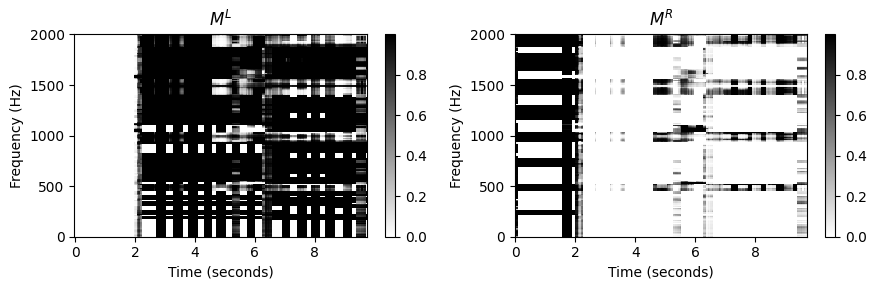

Original signal:


Reconstructed signal for left hand:


Reconstructed signal for right hand:


In [60]:
eps_machine = np.finfo(np.float32).eps
M_L = W.dot(H_L) / (W.dot(H) + eps_machine)
X_L = X * M_L
x_L = librosa.istft(X_L, hop_length=H_fft, win_length=N_fft, length=x.size)

M_R = W.dot(H_R) / (W.dot(H) + eps_machine)
X_R = X * M_R
x_R = librosa.istft(X_R, hop_length=H_fft, win_length=N_fft, length=x.size)

plt.figure(figsize=(9,3))
ax = plt.subplot(1,2,1)
plot_matrix(M_L, Fs=Fs/H_fft, Fs_F=N_fft/Fs, ax=[ax], title=r'$M^L$')
ax.set_ylim([0, freq_max]);

ax = plt.subplot(1,2,2)
plot_matrix(M_R, Fs=Fs/H_fft, Fs_F=N_fft/Fs, ax=[ax], title=r'$M^R$')
ax.set_ylim([0, freq_max]);
plt.tight_layout()
plt.show()

print('Original signal:')
ipd.display(Audio(x, rate=Fs) )
print('Reconstructed signal for left hand:')
ipd.display(Audio(x_L, rate=Fs) )
print('Reconstructed signal for right hand:')
ipd.display(Audio(x_R, rate=Fs) )

## Audio Editing

- 악보 정보의 가용성은 분리 프로세스에 활용될 수 있을 뿐만 아니라 상호 오디오 처리 응용에 대한 사용자 친화적인 액세스를 제공한다. **음별(notewise) 오디오 분해**를 기반으로 동일한 조작을 주어진 오디오 녹음으로 자동 전송할 수 있다.

    * 이를 위해 원본 녹음은 조작된 음의 오디오 이벤트 및 나머지 구성 요소로 분해된다.
    * 이후 각 음별 오디오 이벤트의 원래 피치를 지정된 악보 조작에 따라 적절히 올리거나 내린다. 이러한 사운드 수정 기술은 **피치 이동**이라고도 한다.
    * 마지막으로 수정된 오디오 이벤트가 나머지 구성 요소에 다시 추가된다.

- 유사한 전략을 사용하여 음의 길이나 음량을 변경하거나, 오디오 녹음에서 한 음을 완전히 제거하거나, 기존 음을 복사하고 조작하여 음을 추가할 수도 있다.


- 다음의 예는 악보 기반 오디오 편집의 가능성을 보여준다. 원래 $\mathrm{E}$-minor로 쓰여진 곡은 **조표(key signature)** 를 1샵에서 4샵으로 변경하여 $\mathrm{E}$-메이저로 변환되었다. 이렇게 하면 $\mathrm{C}5$가 $\mathrm{C}^\sharp 5$로, $\mathrm{G}3$가 $\mathrm{G}^\sharp 3$로 이동한다.

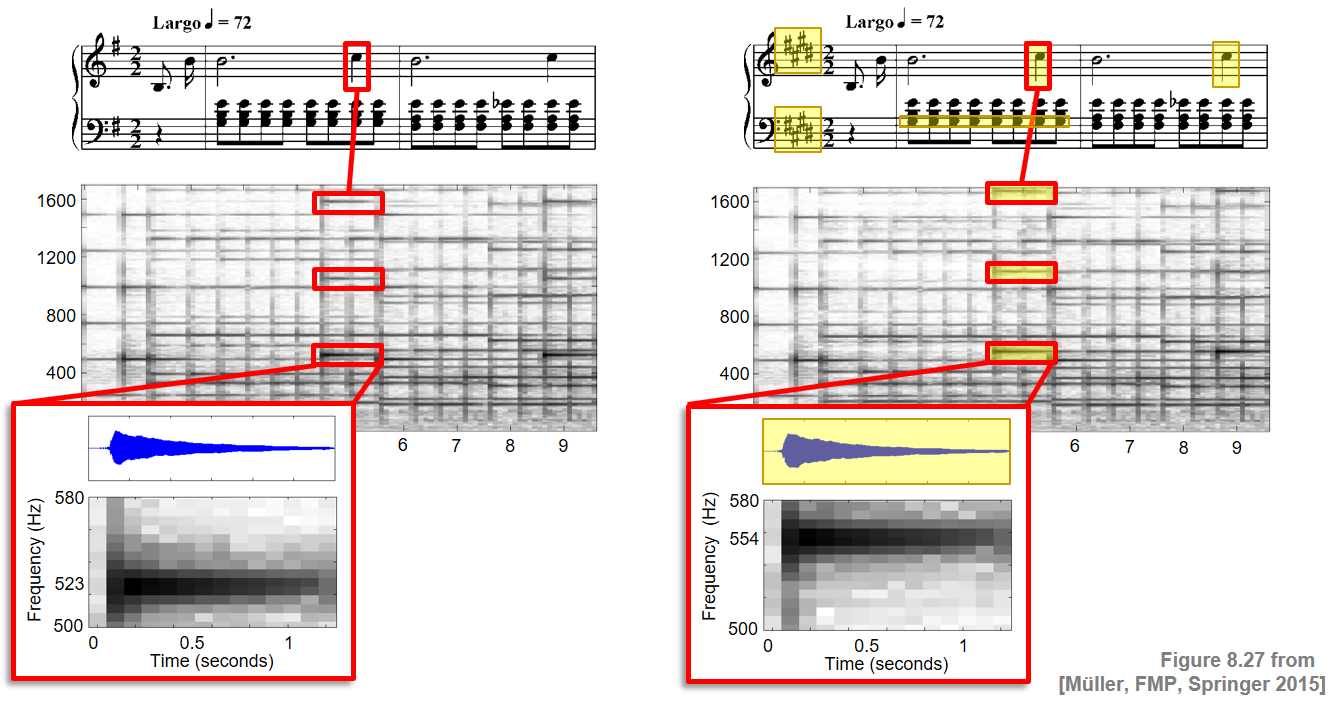

In [61]:
Image(path_img+"FMP_C8_F27.png", width="640px")

In [63]:
ipd.display(Audio(path_data+'FMP_C8_F27_Chopin_Op028-04_minor.wav'))
ipd.display(Audio(path_data+'FMP_C8_F27_Chopin_Op028-04_major.wav'))